In [ ]:
# # cuda delete cache
torch.cuda.empty_cache()

NameError: ignored

In [1]:
!pip install diffusers==0.10.2 transformers scipy ftfy accelerate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [2]:
import torch
import torch.nn as nn
from torch import optim

from typing import Tuple, List
import numpy as np
import torch as th
import os
import json
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from PIL import Image

DEVICE = torch.device('cuda')

In [3]:
import torch
from torch import nn

from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from transformers import AutoProcessor, AutoModel
from tqdm.auto import tqdm
from PIL import Image

In [ ]:
# torch.cuda.empty_cache()

In [4]:
# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")


repo = "Bingsu/clip-vit-large-patch14-ko"
text_encoder = AutoModel.from_pretrained(repo).text_model
tokenizer = AutoProcessor.from_pretrained(repo).tokenizer

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [5]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)
to_tensor = transforms.ToTensor()

In [27]:
# class LearnableVector(nn.Module):
#     def __init__(self):
#         super(LearnableVector, self).__init__()
#         self.learnable_vector = nn.Parameter(torch.randn(4, 768))

#     def forward(self, category):
#         return self.learnable_vector[category]

# lVector = LearnableVector().requires_grad_(True)
# lVector.to(torch_device)

In [12]:
from torch.cuda.amp import GradScaler, autocast

class Model(nn.Module):
    def __init__(self, encoder, vae, unet, scheduler):
        super(Model, self).__init__()
        # self.lVector = lVector
        self.encoder = encoder
        self.vae = vae
        self.unet = unet
        self.scheduler = scheduler
        height = 512                        # default height of Stable Diffusion
        width = 512                         # default width of Stable Diffusion
        num_inference_steps = 100           # Number of denoising steps
        guidance_scale = 7.5                # Scale for classifier-free guidance
        generator = torch.manual_seed(0)    # Seed generator to create the inital latent noise
        self.scaler = GradScaler()

    def forward(self, prompt, category):
        print(prompt)
        batch_size = len(prompt)
        height = 512                        # default height of Stable Diffusion
        width = 512                         # default width of Stable Diffusion
        num_inference_steps = 100           # Number of denoising steps
        guidance_scale = 7.5                # Scale for classifier-free guidance
        generator = torch.manual_seed(0)    # Seed generator to create the inital latent noise
        text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
        text_embeddings = self.encoder(text_input.input_ids.to(torch_device))[0]

        max_length = text_input.input_ids.shape[-1]
        uncond_input = tokenizer(
            [""] * len(prompt), padding="max_length", max_length=max_length, return_tensors="pt"
        )
        uncond_embeddings = self.encoder(uncond_input.input_ids.to(torch_device))[0]

        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
        # expanded_vector = self.lVector.forward(category).repeat(2, 77, 1)
        # text_embeddings = torch.add(expanded_vector, text_embeddings)

        latents = torch.randn(
            (batch_size, unet.in_channels, height // 8, width // 8),
            generator=generator,
        )
        latents = latents.to(torch_device)

        self.scheduler.set_timesteps(20)

        for t in tqdm(self.scheduler.timesteps):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)

            latent_model_input = self.scheduler.scale_model_input(latent_model_input, timestep=t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

        latents = 1 / 0.18215 * latents
        # with torch.no_grad():
        image = self.vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        print("2", type(image))
        images = (image * 255).round().astype("uint8")
        print("3", type(images))
        pil_images = [Image.fromarray(image) for image in images]
        return pil_images[0]


    def sibal(self, prompts, categories, imgs, criterion, optimizer, epoch, batch_size, device):
        print(torch.is_grad_enabled())
        for param in self.encoder.parameters():
            param.requires_grad = False

        # for param in self.lVector.parameters():
        #     param.requires_grad = True

        for param in self.vae.parameters():
            param.requires_grad = True

        for param in self.unet.parameters():
            param.requires_grad = False

        enabled = set()
        for name, param in self.named_parameters():
            if param.requires_grad:
                enabled.add(name)
        print(f"Parameters to be updated: {enabled}")

        for i in range(epoch):
            for j in range(len(prompts)):

                optimizer.zero_grad()

                category = 0 # Hard Coded
                p = []
                p.append(prompts[j])
                with autocast():
                    out = self.forward(p, category)

                    im = imgs[j]
                    im = im.to("cuda")
                    print(out.device, im.device)
                    # tensor_out = to_tensor(out)
                    # tensor_out.requires_grad_(True)
                    # loss = Variable(loss, requires_grad = True)
                    loss = criterion(out, im)
                    im[j].to("cpu")

                # loss.requires_grad_(True)



                self.scaler.scale(loss).backward()
                self.scaler.step(optimizer)
                self.scaler.update()
                # loss.backward()
                # for name, param in self.named_parameters():
                #     if param.grad is not None:
                #         print(name)
                #         print(f"Gradient: {param.grad}")
                # optimizer.step()


                # loss.backward(retain_graph=True)
                # optimizer.step()
                if j % 50 == 0:
                    print('Epoch: %d, [%5d/%5d] loss: %.6f' % (i+1, j*len(prompts), 22222, loss))


In [7]:
def preprocess_image(img) -> th.Tensor:
    transform = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    img = transform(img)
    return img

In [ ]:
# import pandas as pd

# path = '/content/drive/MyDrive/인지프 7팀/데이터 수집/small_data.xlsx'

# df = pd.read_excel(path)
# df.columns = ["index", "title", "author", "gender", "period", "theme", "contents", "is_textbook", "publisher", "image"]
# print(type(df))
# # DataFrame을 딕셔너리의 리스트로 변환
# # obj_list = df.to_dict(orient='records')

# # # obj_list를 JSON 형식으로 저장
# # json_data = json.dumps({'data': obj_list})
# # json_data

In [8]:
text = []
imgs = []

import tqdm

# flag = False
# # iterrows()를 사용하여 각 행을 반복
# for index, row in tqdm.tqdm(df.iterrows(), total=len(df)):
#     # 'contents' 컬럼의 값을 text 리스트에 추가
#     text.append(row['contents'])

#     # 'image' 컬럼의 값을 img_path로 저장하고 출력
#     img_path = f"/content/drive/MyDrive/인지프 7팀/데이터 수집/image{row['image'][1:]}"
#     img = Image.open(img_path).convert('RGB')
#     imgs.append(preprocess_image(img))

#     # 이미지 출력
#     # display(img)

img_path = "/content/sample_data/s_045.jpg"
img = Image.open(img_path).convert('RGB')
imgs.append(preprocess_image(img))
text.append("""
고향이 고향인 줄도 모르면서

긴 장대 휘둘러 까치밥 따는

서울 조카아이들이여

그 까치밥 따지 말라

남도의 빈 겨울 하늘만 남으면

우리 마음 얼마나 허전할까

살아온 이 세상 어느 물굽이

소용돌이치고 휩쓸려 배 주릴 때도

공중을 오가는 날짐승에게 길을 내어 주는

그것은 따뜻한 등불이었으니

철없는 조카아이들이여

그 까치밥 따지 말라

사랑방 말쿠지에 짚신 몇 죽 걸어 놓고

할아버지는 무덤 속을 걸어가시지 않았느냐

그 짚신 더러는 외로운 길손의 길 보시가 되고

한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고

아버지는 다시 새벽 두만강 국경을 넘기도 하였느니

아이들아, 수많은 기다림의 세월

그러니 서러워하지도 말아라

눈 속에 익은 까치밥 몇 개가

겨울 하늘에 떠서

아직도 너희들이 가야 할 머나먼 길

이렇게 등 따숩게 비춰 주고 있지 않으냐.""")

imgs = th.stack(imgs, dim=0)
# imgs = imgs.to(torch_device)

In [11]:
# def dataload(model, tokenizer, prompt, imgs):
#     text_embs = []
#     for e in tqdm.tqdm(text):
#         text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
#         text_embeddings = model.encoder(text_input.input_ids.to(torch_device))[0]

#         max_length = text_input.input_ids.shape[-1]
#         uncond_input = tokenizer(
#             [""] * len(prompt), padding="max_length", max_length=max_length, return_tensors="pt"
#         )
#         uncond_embeddings = model.encoder(uncond_input.input_ids.to(torch_device))[0]

#         text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
#         text_embs.append(text_embeddings)
#     text_embs = th.stack(text_embs, dim=0)

#     k = int(len(text_embs)*0.8)
#     train_dataset = TensorDataset(text_embs[:k], imgs[:k])
#     test_dataset = TensorDataset(text_embs[k:], imgs[k:])

#     train_loader = DataLoader(train_dataset, batch_size=51, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=51, shuffle=True)

#     return train_loader, test_loader

In [13]:
from tqdm.auto import tqdm
model = Model(text_encoder, vae, unet, scheduler)
model.to(torch_device)

Model(
  (encoder): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elemen

In [ ]:
# import tqdm
# train_loader, test_loader = dataload(model, tokenizer, text, imgs)

In [10]:
model.train()

epoch = 500
batch_size=1
lr = 3e-5
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [14]:
prompts = text
categories = [0] * 64

model.sibal([prompts[0]], categories, imgs, criterion, optimizer, epoch, batch_size, DEVICE)


True
Parameters to be updated: {'vae.decoder.up_blocks.3.resnets.2.conv1.bias', 'vae.decoder.up_blocks.2.resnets.1.conv1.weight', 'vae.decoder.up_blocks.1.resnets.2.norm2.bias', 'vae.decoder.up_blocks.2.resnets.1.conv2.bias', 'vae.decoder.up_blocks.0.upsamplers.0.conv.weight', 'vae.decoder.up_blocks.2.resnets.1.conv2.weight', 'vae.encoder.down_blocks.3.resnets.0.conv1.bias', 'vae.encoder.mid_block.attentions.0.group_norm.weight', 'vae.decoder.up_blocks.1.resnets.0.norm1.weight', 'vae.decoder.mid_block.resnets.0.norm1.bias', 'vae.decoder.mid_block.resnets.1.conv2.weight', 'vae.decoder.up_blocks.2.resnets.0.norm2.bias', 'vae.decoder.up_blocks.2.upsamplers.0.conv.weight', 'vae.decoder.mid_block.resnets.1.conv1.weight', 'vae.encoder.down_blocks.0.downsamplers.0.conv.weight', 'vae.encoder.down_blocks.1.resnets.1.norm2.weight', 'vae.encoder.mid_block.resnets.1.conv2.bias', 'vae.decoder.conv_norm_out.weight', 'vae.encoder.mid_block.attentions.0.proj_attn.bias', 'vae.decoder.up_blocks.3.resnet

  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 1, [    0/22222] loss: 3.672575
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 2, [    0/22222] loss: 3.672575
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 3, [    0/22222] loss: 3.318825
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 4, [    0/22222] loss: 3.074868
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 5, [    0/22222] loss: 2.847214
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 6, [    0/22222] loss: 2.603712
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 7, [    0/22222] loss: 2.340325
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 8, [    0/22222] loss: 1.966121
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 9, [    0/22222] loss: 1.708408
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 10, [    0/22222] loss: 1.622171
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 11, [    0/22222] loss: 1.558137
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 12, [    0/22222] loss: 1.513058
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 13, [    0/22222] loss: 1.478603
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 14, [    0/22222] loss: 1.450766
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 15, [    0/22222] loss: 1.429247
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 16, [    0/22222] loss: 1.412824
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 17, [    0/22222] loss: 1.399678
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 18, [    0/22222] loss: 1.388343
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 19, [    0/22222] loss: 1.378063
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 20, [    0/22222] loss: 1.368572
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 21, [    0/22222] loss: 1.359694
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 22, [    0/22222] loss: 1.351439
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 23, [    0/22222] loss: 1.343569
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 24, [    0/22222] loss: 1.335627
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 25, [    0/22222] loss: 1.327263
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 26, [    0/22222] loss: 1.318548
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 27, [    0/22222] loss: 1.309687
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 28, [    0/22222] loss: 1.300160
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 29, [    0/22222] loss: 1.289135
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 30, [    0/22222] loss: 1.275998
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 31, [    0/22222] loss: 1.260208
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 32, [    0/22222] loss: 1.241308
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 33, [    0/22222] loss: 1.219258
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 34, [    0/22222] loss: 1.200831
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 35, [    0/22222] loss: 1.179374
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 36, [    0/22222] loss: 1.166622
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 37, [    0/22222] loss: 1.148029
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 38, [    0/22222] loss: 1.137704
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 39, [    0/22222] loss: 1.135796
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 40, [    0/22222] loss: 1.114629
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 41, [    0/22222] loss: 1.089360
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 42, [    0/22222] loss: 1.084008
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 43, [    0/22222] loss: 1.065460
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 44, [    0/22222] loss: 1.060467
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 45, [    0/22222] loss: 1.040552
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 46, [    0/22222] loss: 1.017977
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 47, [    0/22222] loss: 1.012897
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 48, [    0/22222] loss: 0.996304
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 49, [    0/22222] loss: 0.980445
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 50, [    0/22222] loss: 0.979875
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 51, [    0/22222] loss: 0.945848
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 52, [    0/22222] loss: 0.942925
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 53, [    0/22222] loss: 0.926260
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 54, [    0/22222] loss: 0.917151
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 55, [    0/22222] loss: 0.914436
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 56, [    0/22222] loss: 0.899362
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 57, [    0/22222] loss: 0.901631
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 58, [    0/22222] loss: 0.882232
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 59, [    0/22222] loss: 0.882536
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 60, [    0/22222] loss: 0.867934
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 61, [    0/22222] loss: 0.894157
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 62, [    0/22222] loss: 0.893423
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 63, [    0/22222] loss: 0.900224
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 64, [    0/22222] loss: 0.909924
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 65, [    0/22222] loss: 0.897296
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 66, [    0/22222] loss: 0.896909
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 67, [    0/22222] loss: 0.881395
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 68, [    0/22222] loss: 0.877388
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 69, [    0/22222] loss: 0.861434
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 70, [    0/22222] loss: 0.858356
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 71, [    0/22222] loss: 0.845465
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 72, [    0/22222] loss: 0.828496
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 73, [    0/22222] loss: 0.820771
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 74, [    0/22222] loss: 0.813447
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 75, [    0/22222] loss: 0.826844
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 76, [    0/22222] loss: 0.931798
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 77, [    0/22222] loss: 0.799880
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 78, [    0/22222] loss: 0.884089
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 79, [    0/22222] loss: 0.802385
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 80, [    0/22222] loss: 0.834299
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 81, [    0/22222] loss: 0.794568
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 82, [    0/22222] loss: 0.760276
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 83, [    0/22222] loss: 0.770638
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 84, [    0/22222] loss: 0.753191
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 85, [    0/22222] loss: 0.761085
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 86, [    0/22222] loss: 0.739303
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 87, [    0/22222] loss: 0.736378
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 88, [    0/22222] loss: 0.716411
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 89, [    0/22222] loss: 0.715461
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 90, [    0/22222] loss: 0.702895
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 91, [    0/22222] loss: 0.697925
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 92, [    0/22222] loss: 0.697463
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 93, [    0/22222] loss: 0.687921
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 94, [    0/22222] loss: 0.677079
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 95, [    0/22222] loss: 0.660969
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 96, [    0/22222] loss: 0.650940
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 97, [    0/22222] loss: 0.641510
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 98, [    0/22222] loss: 0.636423
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 99, [    0/22222] loss: 0.638693
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 100, [    0/22222] loss: 0.755418
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 101, [    0/22222] loss: 0.765114
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0
Epoch: 102, [    0/22222] loss: 0.684207
['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

cuda:0 cuda:0


KeyboardInterrupt: ignored

In [15]:
# prompt = ["""
# 귀여운 강아지"""]
# print(prompt)
img = model.forward(text, 0)

['\n고향이 고향인 줄도 모르면서\n\n긴 장대 휘둘러 까치밥 따는\n\n서울 조카아이들이여\n\n그 까치밥 따지 말라\n\n남도의 빈 겨울 하늘만 남으면\n\n우리 마음 얼마나 허전할까\n\n살아온 이 세상 어느 물굽이\n\n소용돌이치고 휩쓸려 배 주릴 때도\n\n공중을 오가는 날짐승에게 길을 내어 주는\n\n그것은 따뜻한 등불이었으니\n\n철없는 조카아이들이여\n\n그 까치밥 따지 말라\n\n사랑방 말쿠지에 짚신 몇 죽 걸어 놓고\n\n할아버지는 무덤 속을 걸어가시지 않았느냐\n\n그 짚신 더러는 외로운 길손의 길 보시가 되고\n\n한밤중 동네 개 컹컹 짖어 그 짚신 짊어지고\n\n아버지는 다시 새벽 두만강 국경을 넘기도 하였느니\n\n아이들아, 수많은 기다림의 세월\n\n그러니 서러워하지도 말아라\n\n눈 속에 익은 까치밥 몇 개가\n\n겨울 하늘에 떠서\n\n아직도 너희들이 가야 할 머나먼 길\n\n이렇게 등 따숩게 비춰 주고 있지 않으냐.']


  0%|          | 0/20 [00:00<?, ?it/s]

1 <class 'torch.Tensor'>
2 <class 'numpy.ndarray'>
3 <class 'numpy.ndarray'>


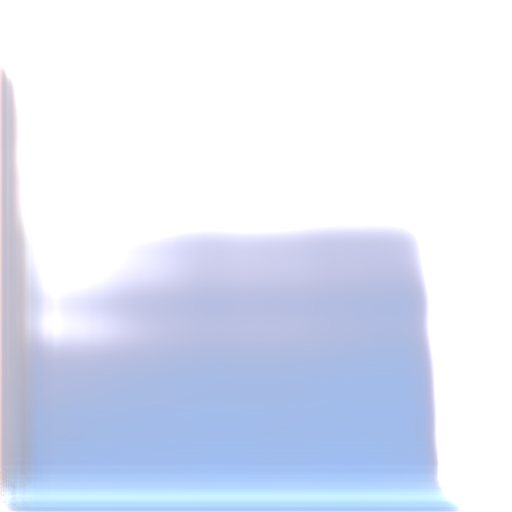

In [19]:
image = img
image = (image / 2 + 0.5).clamp(0, 1)
print("1", type(image))
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
print("2", type(image))
images = (image * 255).round().astype("uint8")
print("3", type(images))
pil_images = [Image.fromarray(image) for image in images]


pil_images[0]

In [ ]:

prompt = ['''
"여름이 뜨거워서
매미가 우는 것이 아니라
매미가 울어서
여름이 뜨거운 것이다

매미는 아는 것이다
사랑이란 이렇게
한사코 너의 옆에 붙어서
뜨겁게 우는 것임을

울지 않으면 보이지 않기 때문에
매미는 우는 것이다"
''']

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100           # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(1999)    # Seed generator to create the inital latent noise

batch_size = len(prompt)

In [ ]:
model.train()

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

In [ ]:
scheduler.set_timesteps(num_inference_steps)

In [ ]:
latents = latents * scheduler.init_noise_sigma

In [ ]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")

pil_images = [Image.fromarray(image) for image in images]
pil_images[0]